In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis

In [72]:
# global variables

# Time window for the event
event_time = pd.to_datetime("2011-03-11 05:46:00")
#start_time = "2011-03-11 05:00:00"
#end_time = "2011-03-11 08:00:00"

# station ID's -> to be filled in
gs1 = 'g103'
gs2 = 'mizu'
gs3 = 'g205'
gs_id = [gs1, gs2, gs3]

# epicenter
epicentre = ((38.321944, 142.368889)) # latitude, longitude -> to be adapted CRS????
epi_lat, epi_lon = epicentre


# Define a sliding window size 
window_size = '15min'  # 10 minutes

In [54]:
# output dir
output_dir = '/workspaces/tsunami-vtec-waves/wave_propagation_speed/'

# Outline

This document is based on df_filtered.csv derived from residuals_plus_bandfilter-3.ipynb\
The csv contains only satellite data of satellites in contact with groundstations during the event window.\
The csv already contains the residuals upon which this file builds up

1. Import filtered data
2. analyse timeseries with curtosis for siginificant peaks ( > 3) using a sliding window
3. norm data with sdv and mean
4. define threshold for when wave arrives at station e.g. 50
5. If threshold is passed -> wave is there, get coordinates and time
6. use horizontal distance and calculate distance to epicenter
7. v = ds/dt




In [55]:
# Load filtered data and set date as index
df = pd.read_csv('df_filtered.csv')
df['datetime'] = pd.to_datetime(df['ut1_unix'], unit='s')
df.set_index('datetime', inplace=True)

# sort by date
df_filtered = df.sort_index()

#filter between start and end time
#df = df.loc[start_time:end_time]

# analyse data columns
df.columns

Index(['year', 'month', 'day', 'hour', 'min', 'sec', 'recno', 'kindat',
       'kinst', 'ut1_unix', 'ut2_unix', 'pierce_alt', 'gps_site', 'sat_id',
       'gnss_type', 'gdlatr', 'gdlonr', 'los_tec', 'dlos_tec', 'tec', 'azm',
       'elm', 'gdlat', 'glon', 'rec_bias', 'drec_bias', 'residuals',
       'band_filtered'],
      dtype='object')

In [56]:
# build dictionary of groundstation and list of satellites in contact with gs at event_time
def get_satellites_in_contact(df, station_id, event_time):
    """
    Check which satellites were in contact with groundstationd during event time
    
    In: Dataframe, ground station id, eventtime
    Out: List of satellite ids which were in contact during event time

    """
    df_filtered = df[(df['gps_site'] == station_id) & (df.index == event_time)]
    satellites_in_contact = df_filtered['sat_id'].unique()

    return satellites_in_contact.tolist()

sat_data = {}
for i in gs_id:
    sat_data[i] = get_satellites_in_contact(df,i,event_time)

## Kurtosis (Wölbung) analysis
$\to$ from https://de.wikipedia.org/wiki/W%C3%B6lbung_(Statistik)


Die *Wölbung* (w), Kyrtosis, Kurtosis oder auch Kurtose (griechisch κύρτωσις kýrtōsis „Krümmen“, „Wölben“) ist eine Maßzahl für die Steilheit bzw. „Spitzigkeit“ einer (eingipfligen) Wahrscheinlichkeitsfunktion, statistischen Dichtefunktion oder Häufigkeitsverteilung.[1] Die Wölbung ist das standardisierte (zentrale) Moment 4. Ordnung. \
Die Wölbung kann nur nicht-negative Werte annehmen.\
- w < 3 $\to$ deutet darauf, dass die standardisierten Beobachtungen $\displaystyle z_{i}$ nahe dem Mittelwert konzentriert sind, d. h. die Verteilung ist flachgipflig
- w > 3  ist die Verteilung im Vergleich zu einer Normalverteilung spitzgipflig $\to$ indiz für peak


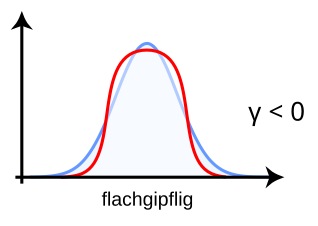 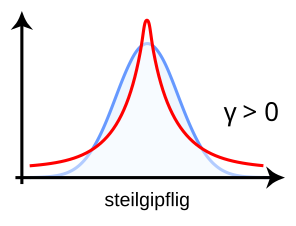


In [57]:
# Function to calculate rolling kurtosis
# calculate kurtosis with scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html)

def calculate_kurtosis(group):
    return group['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)

In [58]:
def kurtosis_wrapper(x):
    return kurtosis(x, fisher=False, bias=False, nan_policy='omit')

In [60]:
# iterate through satellite per groundstaiton and calculate rolling kurtosis
results = []


for station in gs_id:
    for sat_id in sat_data[i]:
        df_sat = df[(df['gps_site'] == station) & (df['sat_id'] == sat_id)]
        df_sat['kurtosis'] = df_sat['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)

        # normalize kurtosis
        df_sat['kurtosis_norm'] = (df_sat['kurtosis'] - df_sat['kurtosis'].mean()) / df_sat['kurtosis'].std()

        # add rolling standard deviation of normalized kurtosis
        df_sat['kurtosis_norm_std'] = df_sat['kurtosis_norm'].rolling(window=window_size).std()

        # store results
        results.append(df_sat)
kurtosis_df = pd.concat(results)
kurtosis_df.head()



/tmp/ipykernel_1760/2642323298.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis'] = df_sat['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)
/tmp/ipykernel_1760/2642323298.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sat['kurtosis_norm'] = (df_sat['kurtosis'] - df_sat['kurtosis'].mean()) / df_sat['kurtosis'].std()
/tmp/ipykernel_1760/2642323298.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,year,month,day,hour,min,sec,recno,kindat,kinst,ut1_unix,...,elm,gdlat,glon,rec_bias,drec_bias,residuals,band_filtered,kurtosis,kurtosis_norm,kurtosis_norm_std
datetime,,,,,,,,,,,,,,,,,,,,,
2011-03-11 05:00:30,2011,3,11,5,0,30,601,3505,8000,1.299820e+09,...,45.181572,39.546185,144.209808,-215218.46875,1.301716,0.001755,0.003808,NaN,NaN,NaN
2011-03-11 05:01:00,2011,3,11,5,1,0,602,3505,8000,1.299820e+09,...,44.985069,39.523426,144.235489,-215218.46875,1.301716,0.018486,-0.004768,1.000000,-2.144028,NaN
2011-03-11 05:01:30,2011,3,11,5,1,30,603,3505,8000,1.299820e+09,...,44.591656,39.486286,144.266464,-215218.46875,1.301716,-0.013489,-0.011294,1.500000,-1.664075,0.339378
2011-03-11 05:02:00,2011,3,11,5,2,0,604,3505,8000,1.299820e+09,...,44.394749,39.472084,144.271729,-215218.46875,1.301716,-0.001074,-0.014604,4.405372,1.124807,1.765101
2011-03-11 05:03:00,2011,3,11,5,3,0,606,3505,8000,1.299820e+09,...,44.197708,39.448849,144.297226,-215218.46875,1.301716,-0.019149,-0.014617,2.832983,-0.384538,1.463576


## normalization of kurtosis 
To define threshold for kurtosis = arrival of wave at location of sat the kurtosis is normalized & standarddeviation is derived over a rolling window

thershold = $3 \sigma$ $\to$ why?



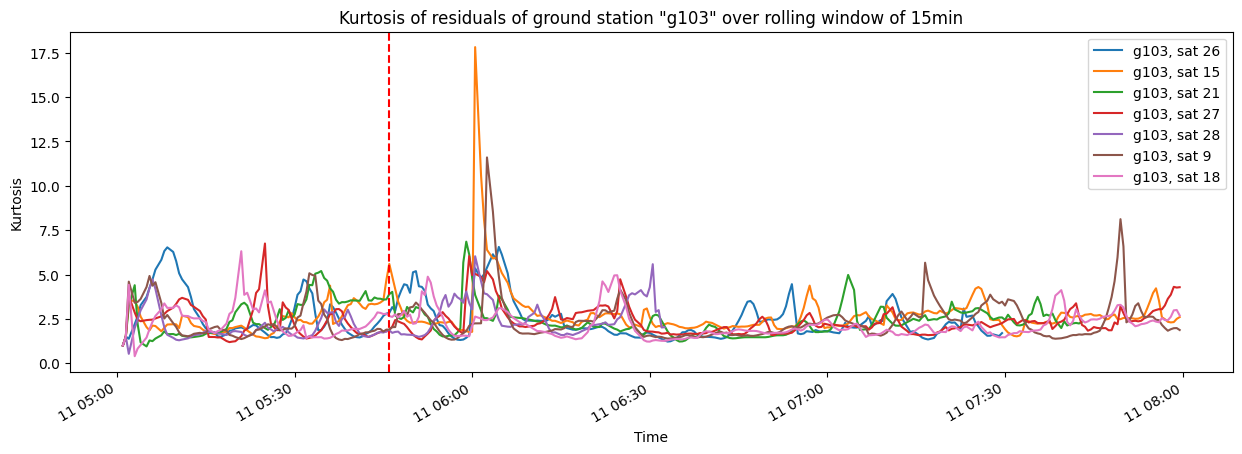

<Figure size 640x480 with 0 Axes>

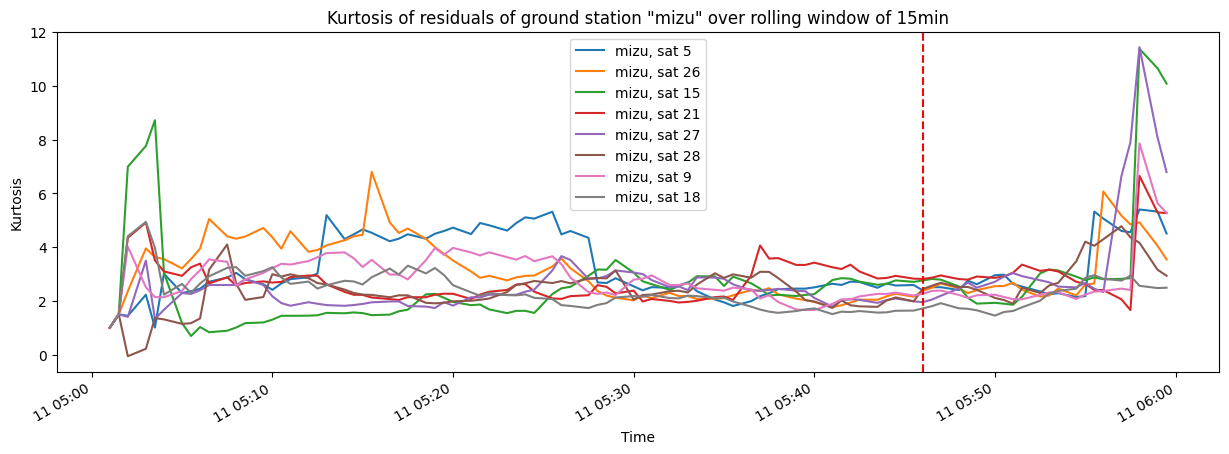

<Figure size 640x480 with 0 Axes>

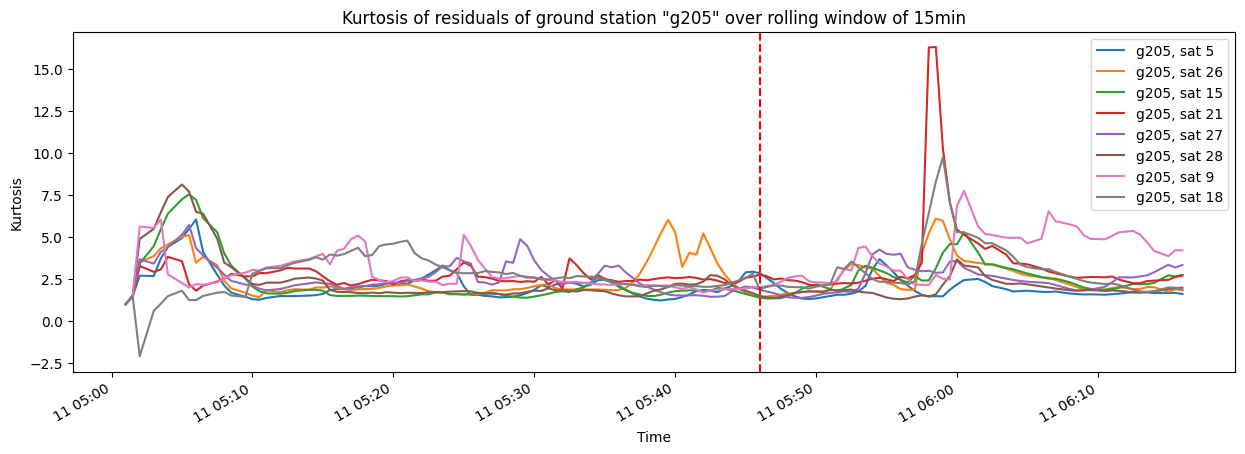

<Figure size 640x480 with 0 Axes>

In [49]:
# plot kurtosis per groundstation highlighting the event time and each satellite in different color
for station in gs_id:
    fig, ax = plt.subplots(figsize=(15, 5))
    for sat_id in sat_data[station]:
        df_sat = kurtosis_df[(kurtosis_df['gps_site'] == station) & (kurtosis_df['sat_id'] == sat_id)]
        df_sat.plot(y='kurtosis', ax=ax, label=f'{station}, sat {sat_id}')
    plt.axvline(x=event_time, color='r', linestyle='--')
    ax.set_xlabel("Time")
    ax.set_ylabel("Kurtosis")
    plt.title(f'Kurtosis of residuals of ground station "{station}" over rolling window of {window_size}')
    plt.show()
    #save to folder wave propagation speed 
    plt.savefig(f"{output_dir}/kurtosis_{station}.png")


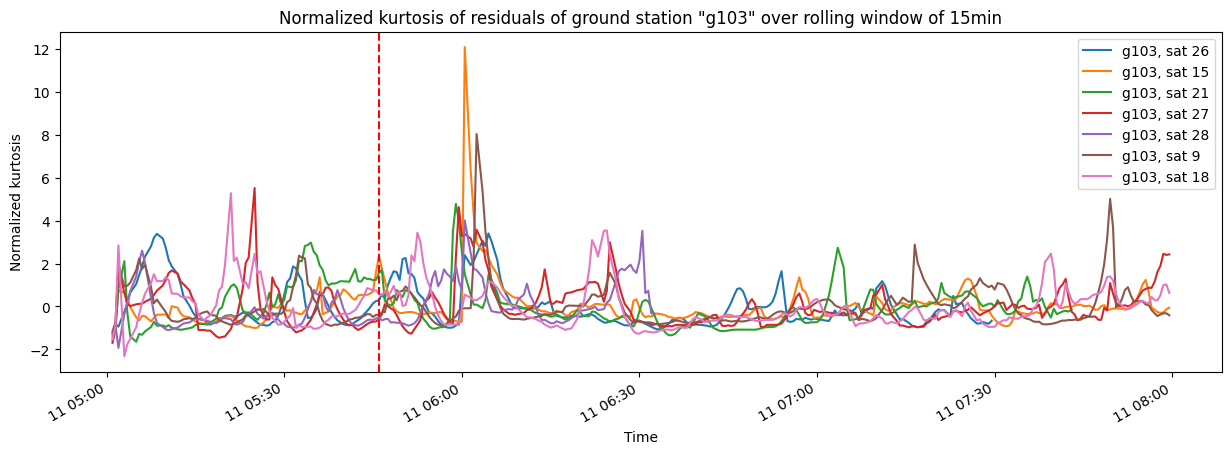

<Figure size 640x480 with 0 Axes>

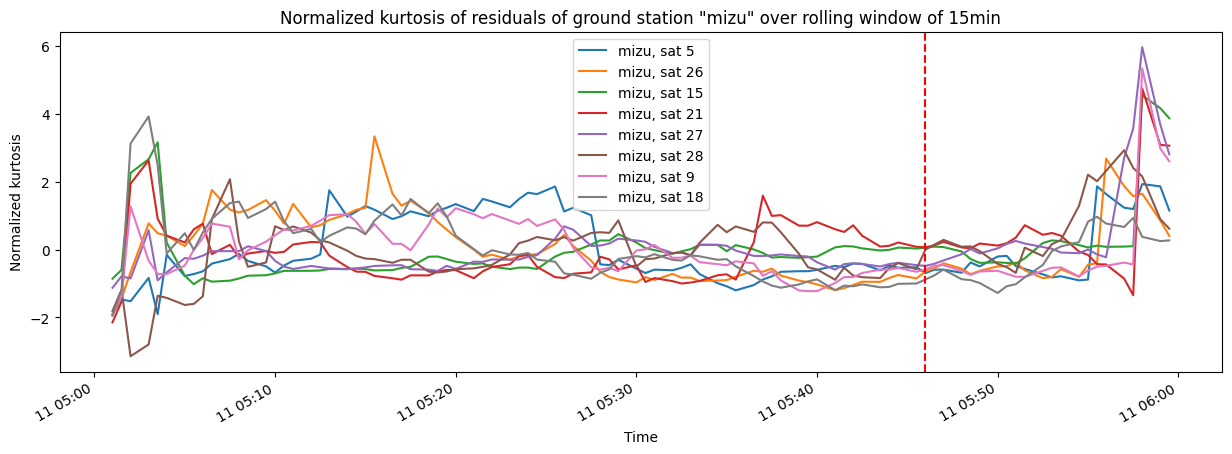

<Figure size 640x480 with 0 Axes>

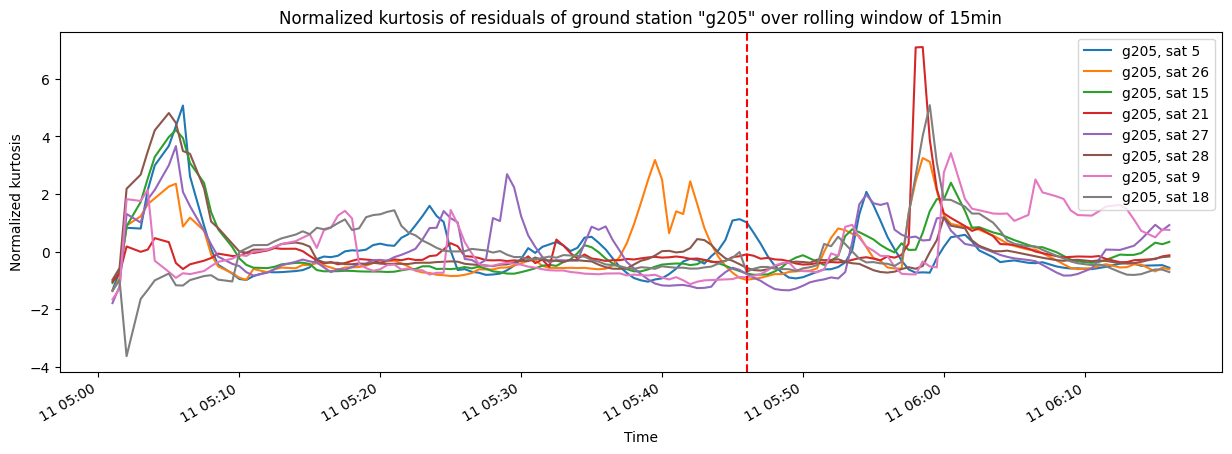

<Figure size 640x480 with 0 Axes>

In [63]:
# plot kurtosis per groundstation highlighting the event time and each satellite in different color
for station in gs_id:
    fig, ax = plt.subplots(figsize=(15, 5))
    for sat_id in sat_data[station]:
        df_sat = kurtosis_df[(kurtosis_df['gps_site'] == station) & (kurtosis_df['sat_id'] == sat_id)]
        df_sat.plot(y='kurtosis_norm', ax=ax, label=f'{station}, sat {sat_id}')
    plt.axvline(x=event_time, color='r', linestyle='--')
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalized kurtosis")
    plt.title(f'Normalized kurtosis of residuals of ground station "{station}" over rolling window of {window_size}')
    plt.show()
    #save to folder wave propagation speed 
    plt.savefig(f"{output_dir}/kurtosis_n_{station}.png")


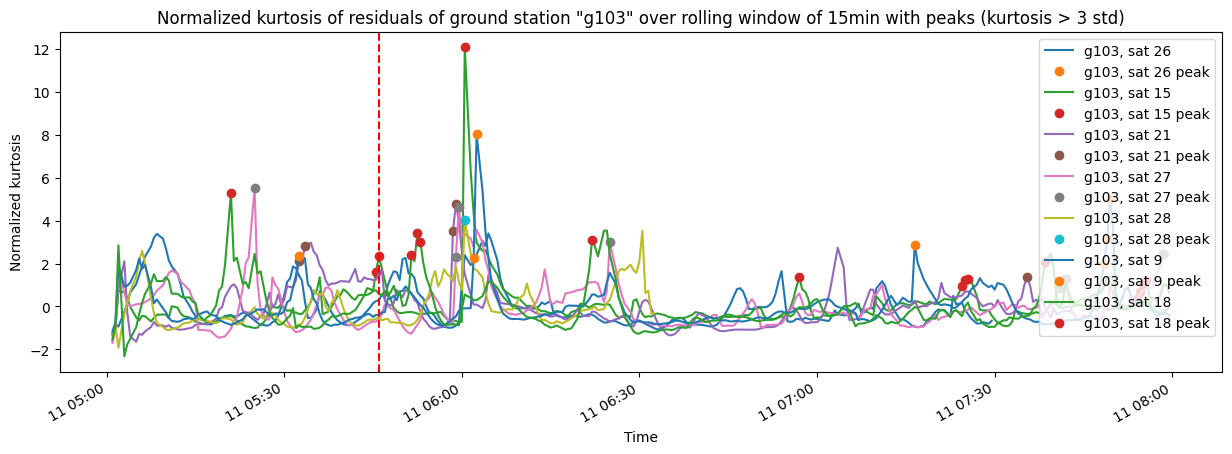

<Figure size 640x480 with 0 Axes>

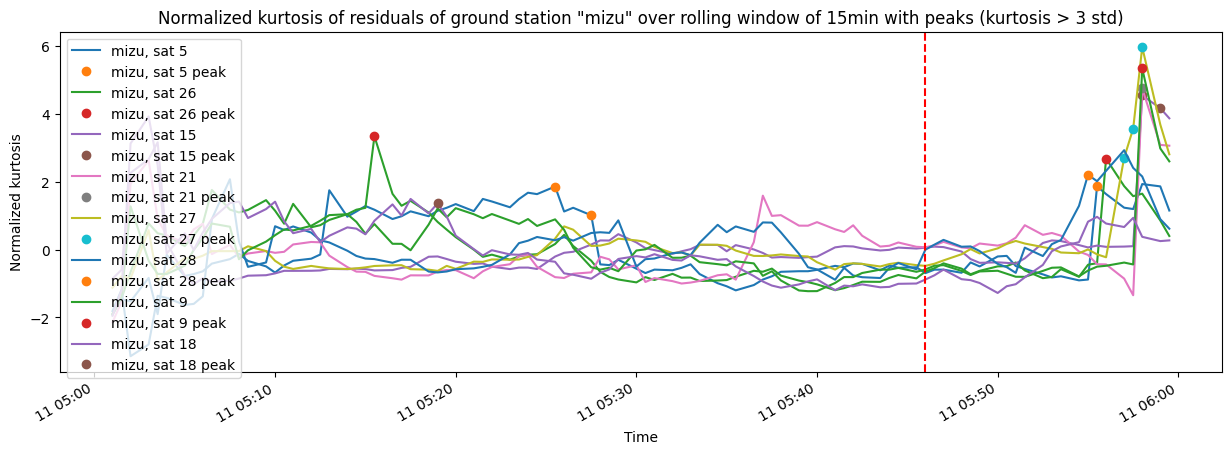

<Figure size 640x480 with 0 Axes>

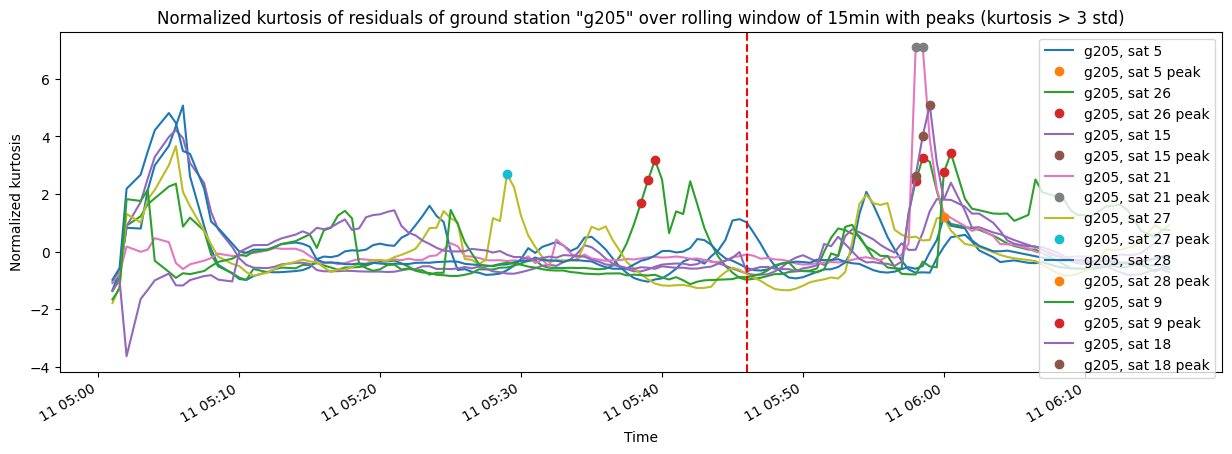

<Figure size 640x480 with 0 Axes>

In [69]:
# peak detection

# peak if kurtosis is above 2 std
kurtosis_df['peak'] = kurtosis_df['kurtosis_norm'] > 3 * kurtosis_df['kurtosis_norm_std']

# plot peaks
for station in gs_id:
    fig, ax = plt.subplots(figsize=(15, 5))
    for sat_id in sat_data[station]:
        df_sat = kurtosis_df[(kurtosis_df['gps_site'] == station) & (kurtosis_df['sat_id'] == sat_id)]
        df_sat.plot(y='kurtosis_norm', ax=ax, label=f'{station}, sat {sat_id}')
        df_sat[df_sat['peak']].plot(y='kurtosis_norm', ax=ax, style='o', label=f'{station}, sat {sat_id} peak')
    plt.axvline(x=event_time, color='r', linestyle='--')
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalized kurtosis")
    plt.title(f'Normalized kurtosis of residuals of ground station "{station}" over rolling window of {window_size} with peaks (kurtosis > 3 std)')
    plt.show()
    #save to folder wave propagation speed 
    plt.savefig(f"{output_dir}/kurtosis_n_{station}_peak.png")


In [75]:
# filter for kurtosis peaks after event time
kurtosis_peaks = kurtosis_df[(kurtosis_df['peak']) & (kurtosis_df.index > event_time)]

# calculate time difference between event time and peak time
kurtosis_peaks['time_diff'] = (kurtosis_peaks.index - event_time).total_seconds()

kurtosis_peaks.head()

/tmp/ipykernel_1760/2957289816.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kurtosis_peaks['time_diff'] = (kurtosis_peaks.index - event_time).total_seconds()


,year,month,day,hour,min,sec,recno,kindat,kinst,ut1_unix,...,glon,rec_bias,drec_bias,residuals,band_filtered,kurtosis,kurtosis_norm,kurtosis_norm_std,peak,time_diff
datetime,,,,,,,,,,,,,,,,,,,,,
2011-03-11 06:00:30,2011,3,11,6,0,30,721,3505,8000,1.299823e+09,...,140.945206,-215216.5,1.301743,0.760444,0.416247,17.820756,12.082117,2.335261,True,870.0
2011-03-11 06:57:00,2011,3,11,6,57,0,834,3505,8000,1.299827e+09,...,142.864792,-215216.5,1.301743,-0.040185,-0.027505,4.374420,1.361200,0.441620,True,4260.0
2011-03-11 07:24:30,2011,3,11,7,24,30,889,3505,8000,1.299828e+09,...,143.839127,-215216.5,1.301743,0.062893,0.046368,3.855601,0.947540,0.232870,True,5910.0
2011-03-11 07:25:00,2011,3,11,7,25,0,890,3505,8000,1.299828e+09,...,143.872009,-215216.5,1.301743,0.086470,0.050273,4.202537,1.224156,0.313184,True,5940.0
2011-03-11 07:25:30,2011,3,11,7,25,30,891,3505,8000,1.299828e+09,...,143.884445,-215216.5,1.301743,0.081543,0.040774,4.293526,1.296702,0.376740,True,5970.0


In [ ]:
# calculate distance between ground station and epicenter
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# calculate distance between ground station and epicenter
kurtosis_peaks['distance'] = haversine(epi_lat, epi_lon, kurtosis_peaks['gdlat'], kurtosis_peaks['glon']) #km


/tmp/ipykernel_1760/2011701678.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kurtosis_peaks['distance'] = haversine(epi_lat, epi_lon, kurtosis_peaks['gdlat'], kurtosis_peaks['glon'])


In [81]:
# calculate wave propagation speed
kurtosis_peaks['wave_speed'] = kurtosis_peaks['distance'] / kurtosis_peaks['time_diff'] #km/s
print(kurtosis_peaks['wave_speed'])

datetime
2011-03-11 06:00:30    0.472810
2011-03-11 06:57:00    0.084442
2011-03-11 07:24:30    0.056268
2011-03-11 07:25:00    0.056004
2011-03-11 07:25:30    0.055614
2011-03-11 07:54:00    0.041484
2011-03-11 07:54:30    0.041333
2011-03-11 07:55:00    0.041184
2011-03-11 07:55:30    0.041038
2011-03-11 05:58:30    0.764994
2011-03-11 05:59:00    0.734767
2011-03-11 07:35:30    0.177780
2011-03-11 05:59:00    0.348857
2011-03-11 05:59:30    0.336982
2011-03-11 06:25:00    0.136298
2011-03-11 07:41:00    0.065960
2011-03-11 07:41:30    0.065942
2011-03-11 07:42:00    0.065742
2011-03-11 07:58:30    0.061999
2011-03-11 06:00:30    1.126794
2011-03-11 06:02:00    0.288231
2011-03-11 06:02:30    0.279990
2011-03-11 07:16:30    0.066720
2011-03-11 07:48:30    0.055227
2011-03-11 07:49:00    0.055134
2011-03-11 07:49:30    0.054986
2011-03-11 05:51:30    2.416282
2011-03-11 05:52:30    2.026482
2011-03-11 05:53:00    1.873364
2011-03-11 06:22:00    0.291570
2011-03-11 07:38:30    0.055826

/tmp/ipykernel_1760/2122343237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kurtosis_peaks['wave_speed'] = kurtosis_peaks['distance'] / kurtosis_peaks['time_diff'] #km/s


## Excess kurtosis
Der **Exzess** gibt die Differenz der Wölbung der betrachteten Funktion zur Wölbung der Dichtefunktion einer normalverteilten Zufallsgröße an.[1]\
Um das Ausmaß der Wölbung besser einschätzen zu können, wird sie mit der Wölbung einer Normalverteilung verglichen, für die $\beta_2 = 3$ gilt. 

Arten von Exzess:

- $\displaystyle \mathrm {Exzess} =0$: normalgipflig oder mesokurtisch. Die Normalverteilung hat die Kurtosis $\displaystyle \beta _{2}=3$ und entsprechend den Exzess .
- $\displaystyle \mathrm {Exzess} >0$: steilgipflig, supergaußförmig oder leptokurtisch. Es handelt sich hierbei um im Vergleich zur Normalverteilung spitzere Verteilungen, d. h. Verteilungen mit starken Peaks.
- $\displaystyle \mathrm {Exzess} <0$: flachgipflig, subgaußförmig oder platykurtisch. Man spricht von einer im Vergleich zur Normalverteilung abgeflachten Verteilung.

# Plotting of residuals per satellite per groundstation

26
datetime
2011-03-11 05:00:30    26
2011-03-11 05:01:00    26
2011-03-11 05:01:30    26
2011-03-11 05:02:00    26
2011-03-11 05:03:00    26
                       ..
2011-03-11 05:57:00    26
2011-03-11 05:57:30    26
2011-03-11 05:58:00    26
2011-03-11 05:59:00    26
2011-03-11 05:59:30    26
Name: sat_id, Length: 494, dtype: int64


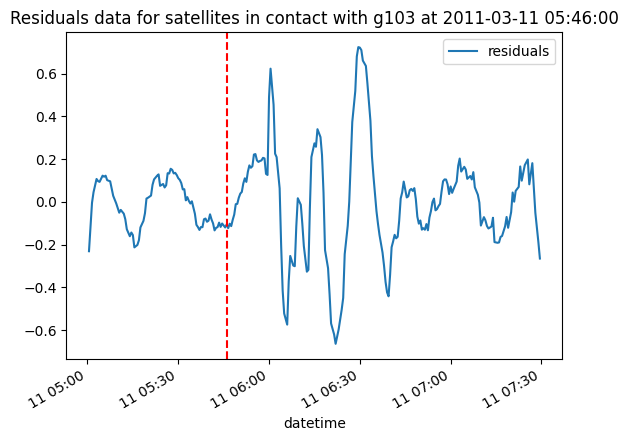

15
datetime
2011-03-11 05:00:30    15
2011-03-11 05:01:00    15
2011-03-11 05:01:30    15
2011-03-11 05:02:00    15
2011-03-11 05:03:00    15
                       ..
2011-03-11 05:57:00    15
2011-03-11 05:57:30    15
2011-03-11 05:58:00    15
2011-03-11 05:59:00    15
2011-03-11 05:59:30    15
Name: sat_id, Length: 553, dtype: int64


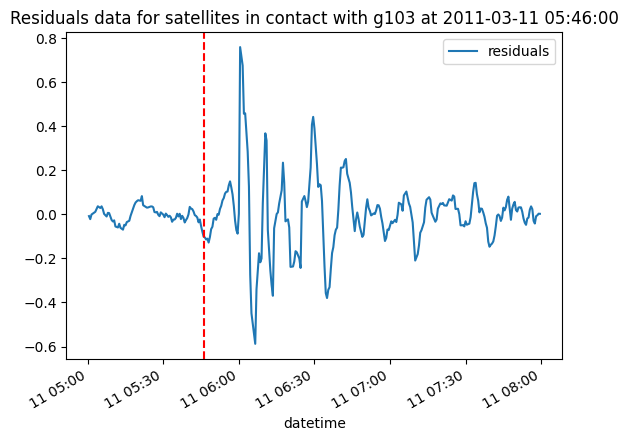

21
datetime
2011-03-11 05:00:30    21
2011-03-11 05:01:00    21
2011-03-11 05:01:30    21
2011-03-11 05:02:00    21
2011-03-11 05:03:00    21
                       ..
2011-03-11 05:57:00    21
2011-03-11 05:57:30    21
2011-03-11 05:58:00    21
2011-03-11 05:59:00    21
2011-03-11 05:59:30    21
Name: sat_id, Length: 520, dtype: int64


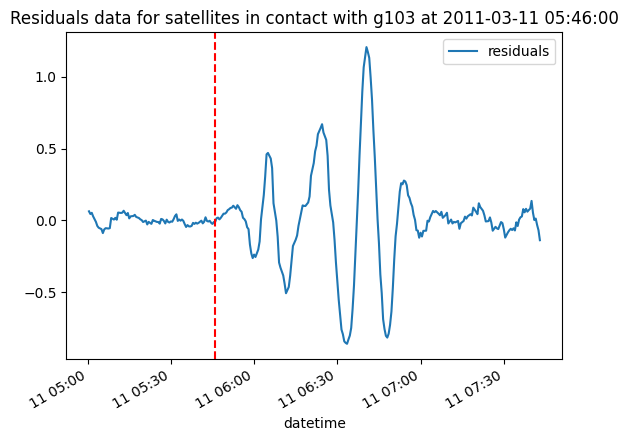

27
datetime
2011-03-11 05:00:30    27
2011-03-11 05:01:00    27
2011-03-11 05:01:30    27
2011-03-11 05:02:00    27
2011-03-11 05:03:00    27
                       ..
2011-03-11 05:57:00    27
2011-03-11 05:57:30    27
2011-03-11 05:58:00    27
2011-03-11 05:59:00    27
2011-03-11 05:59:30    27
Name: sat_id, Length: 553, dtype: int64


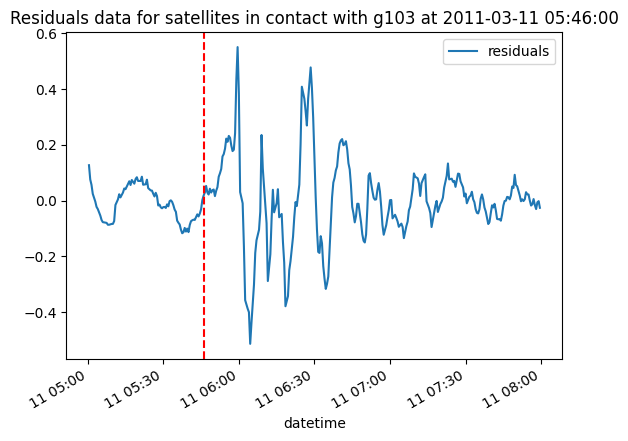

28
datetime
2011-03-11 05:00:30    28
2011-03-11 05:01:00    28
2011-03-11 05:01:30    28
2011-03-11 05:02:00    28
2011-03-11 05:03:00    28
                       ..
2011-03-11 05:57:00    28
2011-03-11 05:57:30    28
2011-03-11 05:58:00    28
2011-03-11 05:59:00    28
2011-03-11 05:59:30    28
Name: sat_id, Length: 393, dtype: int64


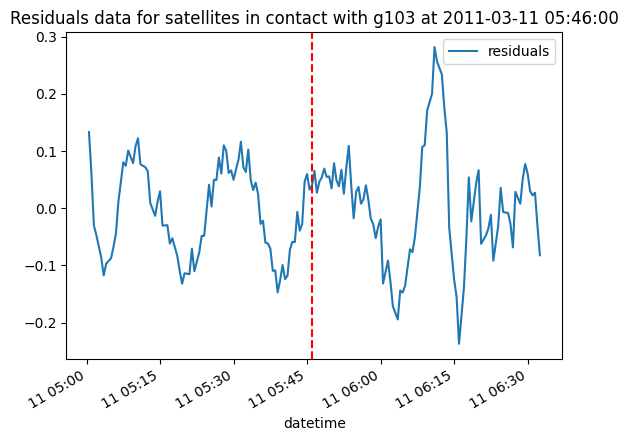

9
datetime
2011-03-11 05:00:30    9
2011-03-11 05:01:00    9
2011-03-11 05:01:30    9
2011-03-11 05:02:00    9
2011-03-11 05:03:00    9
                      ..
2011-03-11 05:57:00    9
2011-03-11 05:57:30    9
2011-03-11 05:58:00    9
2011-03-11 05:59:00    9
2011-03-11 05:59:30    9
Name: sat_id, Length: 553, dtype: int64


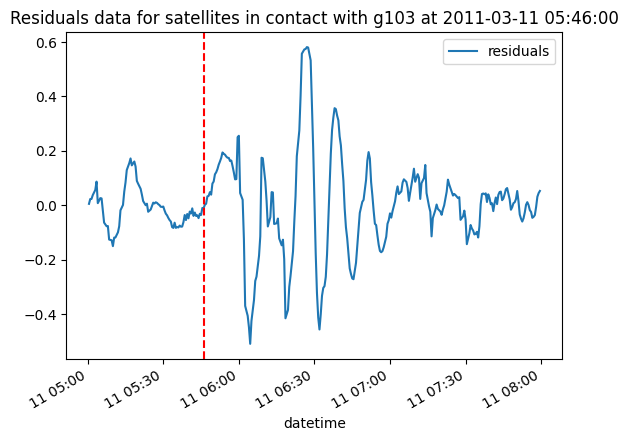

18
datetime
2011-03-11 05:00:30    18
2011-03-11 05:01:00    18
2011-03-11 05:01:30    18
2011-03-11 05:02:00    18
2011-03-11 05:03:00    18
                       ..
2011-03-11 05:57:00    18
2011-03-11 05:57:30    18
2011-03-11 05:58:00    18
2011-03-11 05:59:00    18
2011-03-11 05:59:30    18
Name: sat_id, Length: 553, dtype: int64


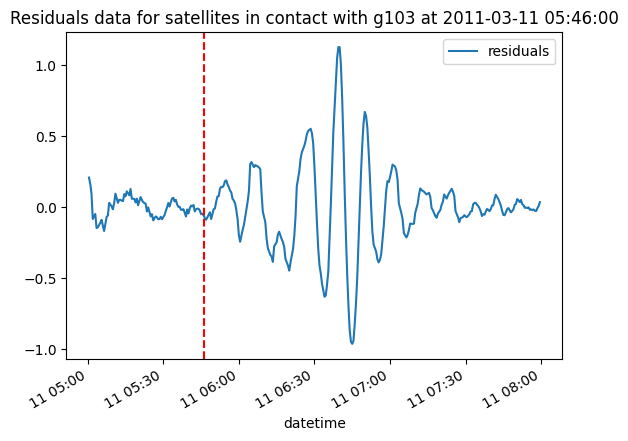

5
datetime
2011-03-11 05:00:30    5
2011-03-11 05:01:00    5
2011-03-11 05:01:30    5
2011-03-11 05:02:00    5
2011-03-11 05:03:00    5
                      ..
2011-03-11 05:57:00    5
2011-03-11 05:57:30    5
2011-03-11 05:58:00    5
2011-03-11 05:59:00    5
2011-03-11 05:59:30    5
Name: sat_id, Length: 311, dtype: int64


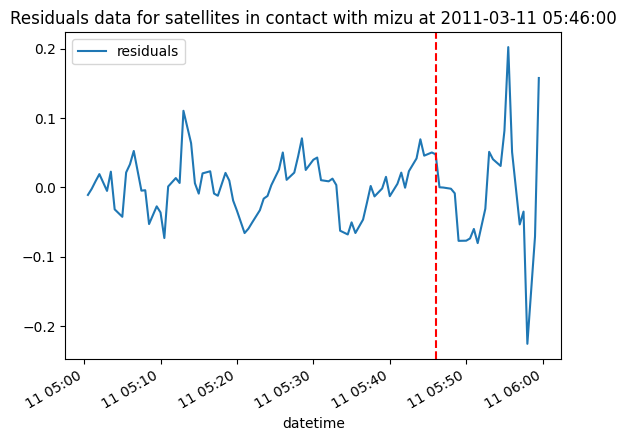

26
datetime
2011-03-11 05:00:30    26
2011-03-11 05:01:00    26
2011-03-11 05:01:30    26
2011-03-11 05:02:00    26
2011-03-11 05:03:00    26
                       ..
2011-03-11 05:57:00    26
2011-03-11 05:57:30    26
2011-03-11 05:58:00    26
2011-03-11 05:59:00    26
2011-03-11 05:59:30    26
Name: sat_id, Length: 494, dtype: int64


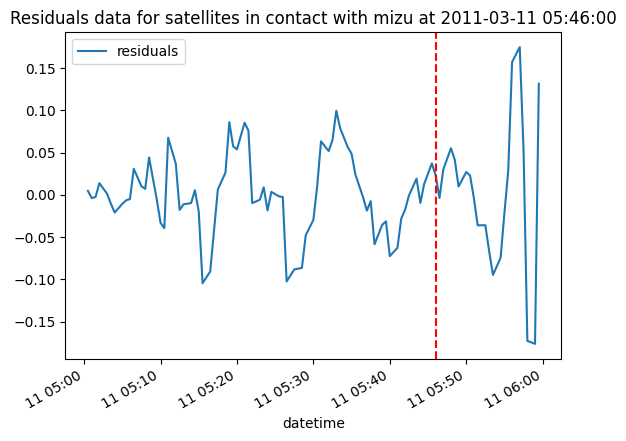

15
datetime
2011-03-11 05:00:30    15
2011-03-11 05:01:00    15
2011-03-11 05:01:30    15
2011-03-11 05:02:00    15
2011-03-11 05:03:00    15
                       ..
2011-03-11 05:57:00    15
2011-03-11 05:57:30    15
2011-03-11 05:58:00    15
2011-03-11 05:59:00    15
2011-03-11 05:59:30    15
Name: sat_id, Length: 553, dtype: int64


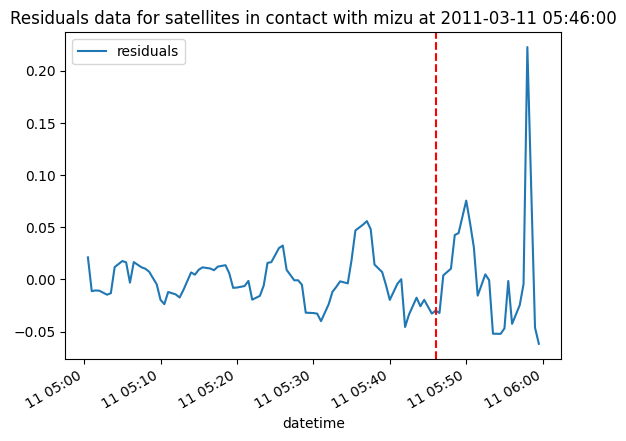

21
datetime
2011-03-11 05:00:30    21
2011-03-11 05:01:00    21
2011-03-11 05:01:30    21
2011-03-11 05:02:00    21
2011-03-11 05:03:00    21
                       ..
2011-03-11 05:57:00    21
2011-03-11 05:57:30    21
2011-03-11 05:58:00    21
2011-03-11 05:59:00    21
2011-03-11 05:59:30    21
Name: sat_id, Length: 520, dtype: int64


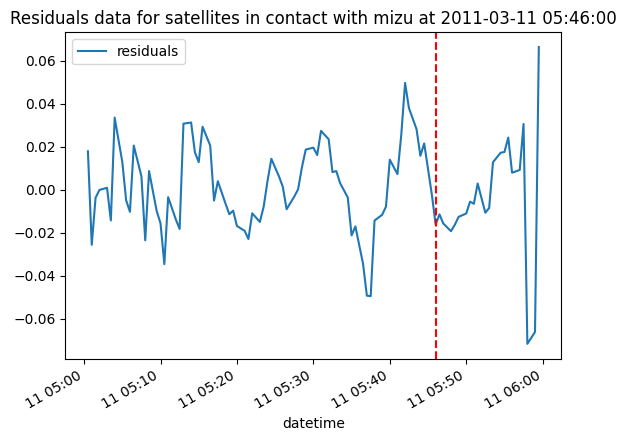

27
datetime
2011-03-11 05:00:30    27
2011-03-11 05:01:00    27
2011-03-11 05:01:30    27
2011-03-11 05:02:00    27
2011-03-11 05:03:00    27
                       ..
2011-03-11 05:57:00    27
2011-03-11 05:57:30    27
2011-03-11 05:58:00    27
2011-03-11 05:59:00    27
2011-03-11 05:59:30    27
Name: sat_id, Length: 553, dtype: int64


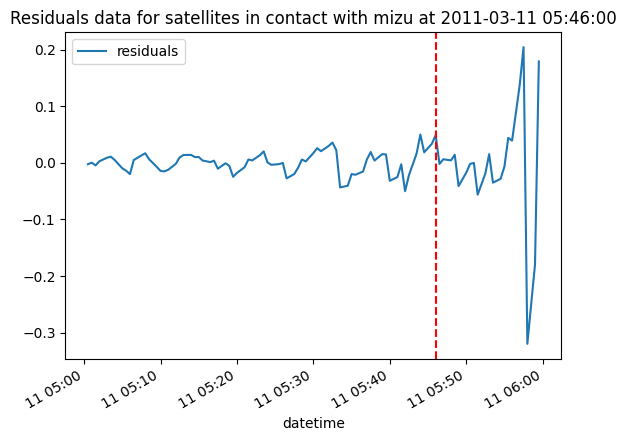

28
datetime
2011-03-11 05:00:30    28
2011-03-11 05:01:00    28
2011-03-11 05:01:30    28
2011-03-11 05:02:00    28
2011-03-11 05:03:00    28
                       ..
2011-03-11 05:57:00    28
2011-03-11 05:57:30    28
2011-03-11 05:58:00    28
2011-03-11 05:59:00    28
2011-03-11 05:59:30    28
Name: sat_id, Length: 393, dtype: int64


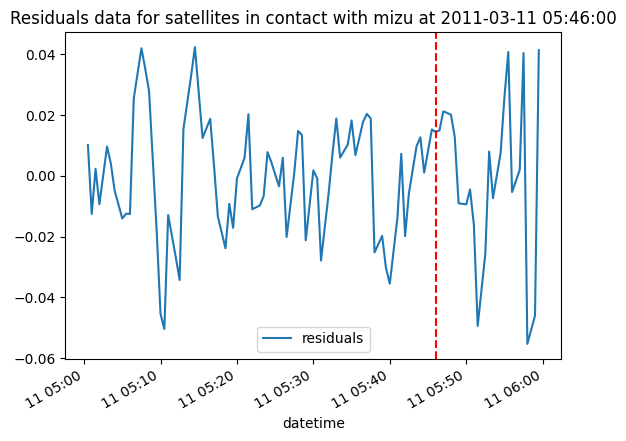

9
datetime
2011-03-11 05:00:30    9
2011-03-11 05:01:00    9
2011-03-11 05:01:30    9
2011-03-11 05:02:00    9
2011-03-11 05:03:00    9
                      ..
2011-03-11 05:57:00    9
2011-03-11 05:57:30    9
2011-03-11 05:58:00    9
2011-03-11 05:59:00    9
2011-03-11 05:59:30    9
Name: sat_id, Length: 553, dtype: int64


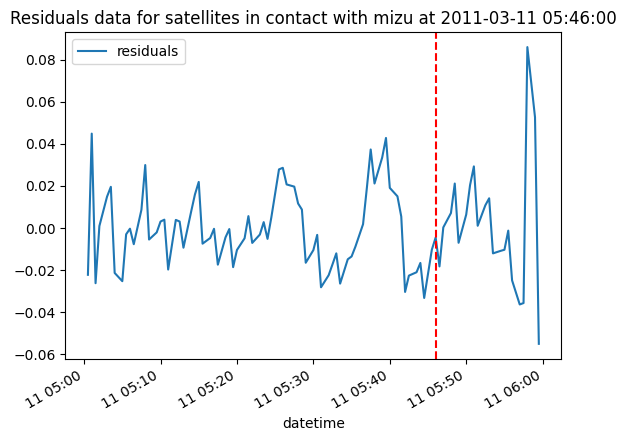

18
datetime
2011-03-11 05:00:30    18
2011-03-11 05:01:00    18
2011-03-11 05:01:30    18
2011-03-11 05:02:00    18
2011-03-11 05:03:00    18
                       ..
2011-03-11 05:57:00    18
2011-03-11 05:57:30    18
2011-03-11 05:58:00    18
2011-03-11 05:59:00    18
2011-03-11 05:59:30    18
Name: sat_id, Length: 553, dtype: int64


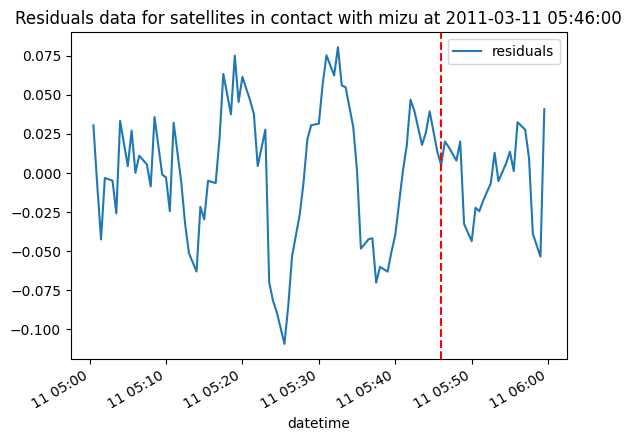

5
datetime
2011-03-11 05:00:30    5
2011-03-11 05:01:00    5
2011-03-11 05:01:30    5
2011-03-11 05:02:00    5
2011-03-11 05:03:00    5
                      ..
2011-03-11 05:57:00    5
2011-03-11 05:57:30    5
2011-03-11 05:58:00    5
2011-03-11 05:59:00    5
2011-03-11 05:59:30    5
Name: sat_id, Length: 311, dtype: int64


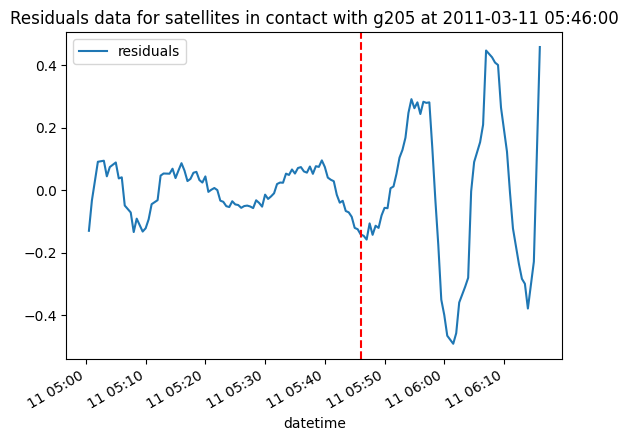

26
datetime
2011-03-11 05:00:30    26
2011-03-11 05:01:00    26
2011-03-11 05:01:30    26
2011-03-11 05:02:00    26
2011-03-11 05:03:00    26
                       ..
2011-03-11 05:57:00    26
2011-03-11 05:57:30    26
2011-03-11 05:58:00    26
2011-03-11 05:59:00    26
2011-03-11 05:59:30    26
Name: sat_id, Length: 494, dtype: int64


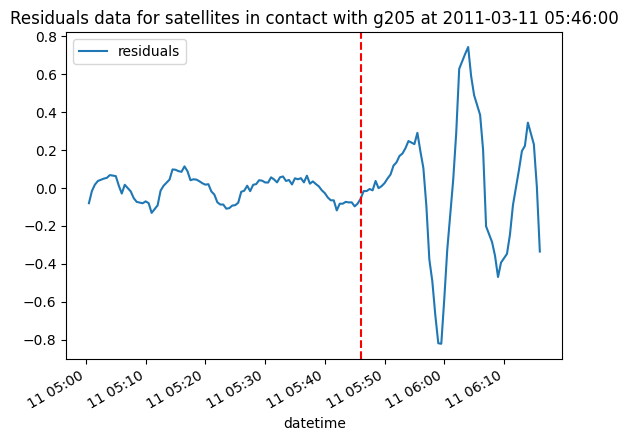

15
datetime
2011-03-11 05:00:30    15
2011-03-11 05:01:00    15
2011-03-11 05:01:30    15
2011-03-11 05:02:00    15
2011-03-11 05:03:00    15
                       ..
2011-03-11 05:57:00    15
2011-03-11 05:57:30    15
2011-03-11 05:58:00    15
2011-03-11 05:59:00    15
2011-03-11 05:59:30    15
Name: sat_id, Length: 553, dtype: int64


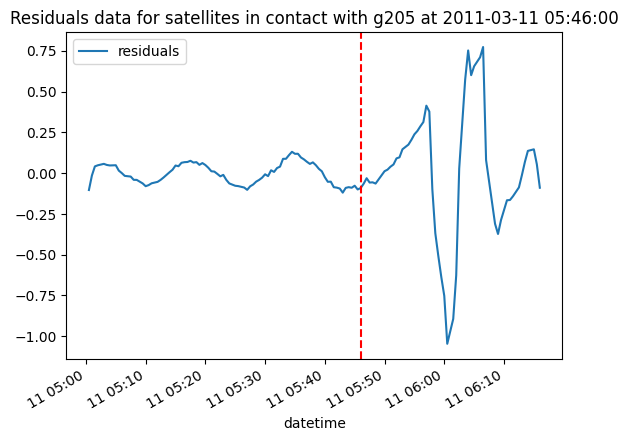

21
datetime
2011-03-11 05:00:30    21
2011-03-11 05:01:00    21
2011-03-11 05:01:30    21
2011-03-11 05:02:00    21
2011-03-11 05:03:00    21
                       ..
2011-03-11 05:57:00    21
2011-03-11 05:57:30    21
2011-03-11 05:58:00    21
2011-03-11 05:59:00    21
2011-03-11 05:59:30    21
Name: sat_id, Length: 520, dtype: int64


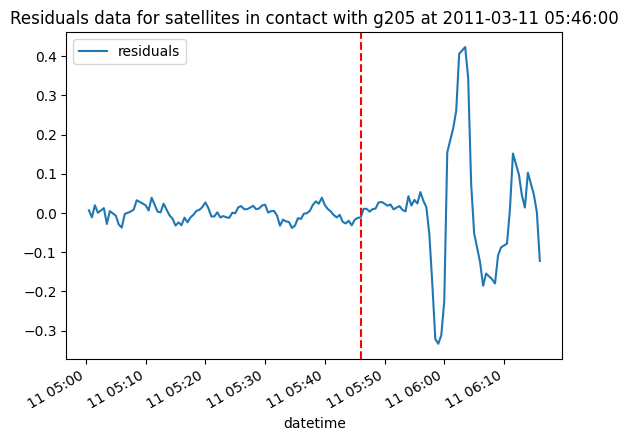

27
datetime
2011-03-11 05:00:30    27
2011-03-11 05:01:00    27
2011-03-11 05:01:30    27
2011-03-11 05:02:00    27
2011-03-11 05:03:00    27
                       ..
2011-03-11 05:57:00    27
2011-03-11 05:57:30    27
2011-03-11 05:58:00    27
2011-03-11 05:59:00    27
2011-03-11 05:59:30    27
Name: sat_id, Length: 553, dtype: int64


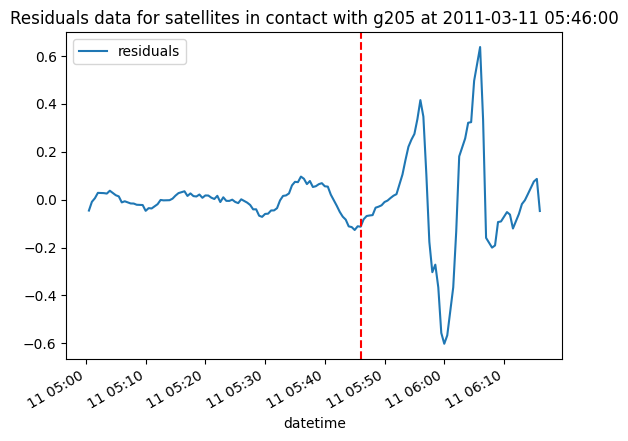

28
datetime
2011-03-11 05:00:30    28
2011-03-11 05:01:00    28
2011-03-11 05:01:30    28
2011-03-11 05:02:00    28
2011-03-11 05:03:00    28
                       ..
2011-03-11 05:57:00    28
2011-03-11 05:57:30    28
2011-03-11 05:58:00    28
2011-03-11 05:59:00    28
2011-03-11 05:59:30    28
Name: sat_id, Length: 393, dtype: int64


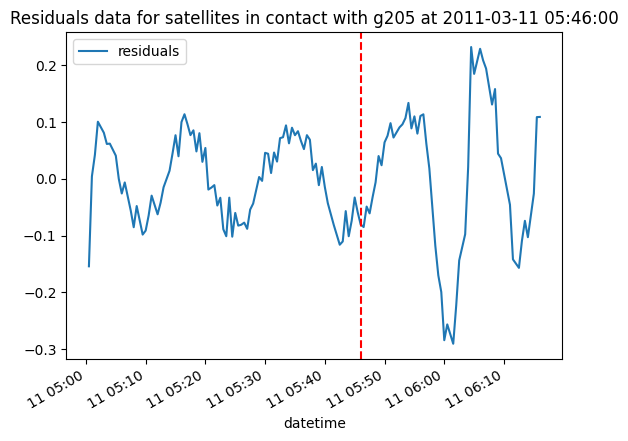

9
datetime
2011-03-11 05:00:30    9
2011-03-11 05:01:00    9
2011-03-11 05:01:30    9
2011-03-11 05:02:00    9
2011-03-11 05:03:00    9
                      ..
2011-03-11 05:57:00    9
2011-03-11 05:57:30    9
2011-03-11 05:58:00    9
2011-03-11 05:59:00    9
2011-03-11 05:59:30    9
Name: sat_id, Length: 553, dtype: int64


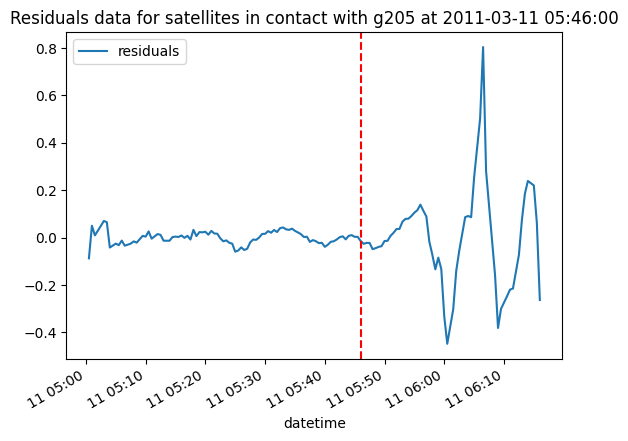

18
datetime
2011-03-11 05:00:30    18
2011-03-11 05:01:00    18
2011-03-11 05:01:30    18
2011-03-11 05:02:00    18
2011-03-11 05:03:00    18
                       ..
2011-03-11 05:57:00    18
2011-03-11 05:57:30    18
2011-03-11 05:58:00    18
2011-03-11 05:59:00    18
2011-03-11 05:59:30    18
Name: sat_id, Length: 553, dtype: int64


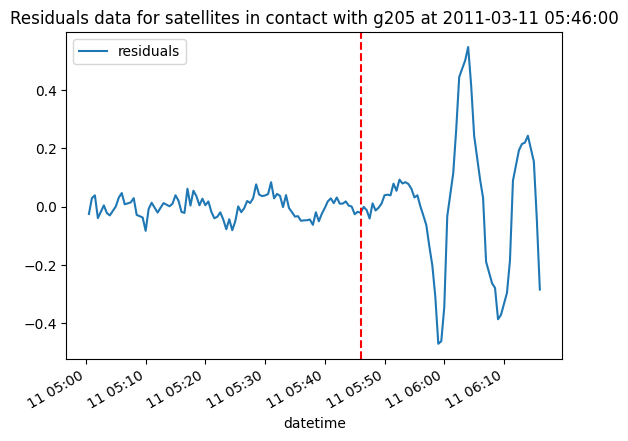

In [ ]:
# plot residuals for each satellite in contact with groundstation
def plot_tec(df, sat_id, station_id, event_time):
    #filter for satellites in df
    df_filtered = df[(df['gps_site'] == station_id) & (df['sat_id'] == sat_id)]
    df_filtered.plot(y = 'residuals', title = f'Residuals data for satellites in contact with {station_id} at {event_time}')
    # indicate event
    plt.axvline(x=event_time, color='r', linestyle='--',label="Event Marker")
    plt.show()
for i in gs_id:
    for sat_id in sat_data[i]:
        print(sat_id)
        print(df.loc[df['sat_id'] == sat_id, 'sat_id'])
        plot_tec(df, sat_id, i, event_time)
    